In [ ]:
# @title Install dependencies
!pip install opencv-python --quiet
!pip install google.colab --quiet

     |████████████████████████████████| 1.6 MB 29.5 MB/s 


In [ ]:
!pip install tensorflow-io --quiet

In [ ]:
!pip install tensorflow-hub --quiet

In [ ]:
# Imports
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import torch
import torchvision

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import tqdm
import time
from glob import glob

import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Define function to run pose estimation using MoveNet Thunder.


In [ ]:
# Download model from TF Hub and check out inference code from GitHub
!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

def detect(input_tensor, inference_count=3):
  image_height, image_width, channel = input_tensor.shape
  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)
  # Repeatedly using previous detection result to identify the region of interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(), 
                            reset_crop_region=False)

  return person

Cloning into 'examples'...
remote: Enumerating objects: 22843, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 22843 (delta 12), reused 18 (delta 5), pack-reused 22813
Receiving objects: 100% (22843/22843), 42.07 MiB | 32.64 MiB/s, done.
Resolving deltas: 100% (12549/12549), done.


In [ ]:
gDrive = True

In [ ]:
#set the `gDrive=True` and run the cell.
from google.colab import drive

if gDrive:
  print('The first time you run this, it will ask you to verify that Google Colab can access your Google Drive.')
  print('Follow the instructions -- go to the linked website, and copy-paste the provided code.')
  drive.flush_and_unmount()
  drive.mount('/content/drive', force_remount=True)
  assert os.path.exists('/content/drive/My Drive'), 'Google drive not mounted'

  # Unzip cricket shot pose data
  datadir = 'data'
  if not os.path.exists(datadir):
    assert os.path.exists('/content/drive/My Drive/data.zip'), 'cricket shot pose data zip file not found'
    !unzip -q '/content/drive/My Drive/data.zip' > /dev/null
    assert os.path.exists(datadir), 'view0 not created after unzipping data'
  else:
    print('Cricket pose data already unzipped')

The first time you run this, it will ask you to verify that Google Colab can access your Google Drive.
Follow the instructions -- go to the linked website, and copy-paste the provided code.
Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
#@title Functions to visualize the pose estimation results.
def draw_prediction_on_image(
    image, person, crop_region=None, close_figure=True,
    keep_input_size=False):
  
  # Draw the detection result on top of the image.
  image_np = utils.visualize(image, [person])
  
  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12*aspect_ratio, 12))
  im = ax.imshow(image_np)
 
  if close_figure:
    plt.close(fig)
 
  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

"""Creates a preprocessor to detection pose from images and save as CSV.

In [ ]:
#@title Code to load the images, detect pose landmarks and save them into a CSV file
class MoveNetPreprocessor(object):
  """Helper class to preprocess pose sample images for classification."""
  def __init__(self,images_in_folder,images_out_folder,csvs_out_path):
    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []

    # Create a temp dir to store the pose CSVs per class
    self._csvs_out_folder_per_class = tempfile.mkdtemp()
 
    # Get list of pose classes and print image statistics
    self._pose_class_names = sorted([n for n in os.listdir(self._images_in_folder) if not n.startswith('.')])
    
  def process(self, per_pose_class_limit=None, detection_threshold=0.1):
    # Loop through the classes and preprocess its images
    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)

      # Paths for the pose class.
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class, pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)
 
      # Detect landmarks in each image and write it to a CSV file
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
        # Get list of images
        image_names = sorted([n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        valid_image_count = 0
 
        # Detect pose landmarks from each image
        for image_name in tqdm.tqdm(image_names):
          image_path = os.path.join(images_in_folder, image_name)

          try:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            image = tfio.experimental.color.bgr_to_rgb(image, name=None)
            
          except:
            self._messages.append('Skipped ' + image_path + '. Invalid image.')
            continue
          else:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            image = tfio.experimental.color.bgr_to_rgb(image, name=None)
            image_height, image_width, channel = image.shape
          # Skip images that isn't RGB because Movenet requires RGB images
          if channel != 3:
            self._messages.append('Skipped ' + image_path +'. Image isn\'t in RGB format.')
            continue
          person = detect(image)
          
          # Save landmarks if all landmarks were detected
          min_landmark_score = min([keypoint.score for keypoint in person.keypoints])
          should_keep_image = min_landmark_score >= detection_threshold
          if not should_keep_image:
            self._messages.append('Skipped ' + image_path +'. No pose was confidentlly detected.')
            continue

          valid_image_count += 1

          # Draw the prediction result on top of the image for debugging later
          output_overlay = draw_prediction_on_image(image.numpy().astype(np.uint8), person, close_figure=True, keep_input_size=True)
        
          # Write detection result into an image file
          output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_BGR2RGB)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)
        
          # Get landmarks and scale it to the same size as the input image
          pose_landmarks = np.array([[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                for keypoint in person.keypoints],dtype=np.float32)

          # Write the landmark coordinates to its per-class CSV file
          coordinates = pose_landmarks.flatten().astype(np.str).tolist()
          csv_out_writer.writerow([image_name] + coordinates)

        if not valid_image_count:
          raise RuntimeError('No valid images found for the "{}" class.'.format(pose_class_name))
      
    # Print the error message collected during preprocessing.
    print('\n'.join(self._messages))

    # Combine all per-class CSVs into a single output file
    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    """List of classes found in the training dataset."""
    return self._pose_class_names
  
  def _all_landmarks_as_dataframe(self):
    """Merge all per-class CSVs into a single dataframe."""
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      csv_out_path = os.path.join(self._csvs_out_folder_per_class, class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)
      
      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column (first column)
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '') + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)
 
    list_name = [[bodypart.name + '_x', bodypart.name + '_y', bodypart.name + '_score'] for bodypart in BodyPart] 
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i] for i in range(len(header_name))}
 
    total_df.rename(header_map, axis=1, inplace=True)

    return total_df

In [ ]:
import random
import shutil
def split_into_train_test(images_origin, images_dest, test_split): 
  _, dirs, _ = next(os.walk(images_origin))
  TRAIN_DIR = os.path.join(images_dest, 'train')
  TEST_DIR = os.path.join(images_dest, 'test')
  os.makedirs(TRAIN_DIR, exist_ok=True)
  os.makedirs(TEST_DIR, exist_ok=True)

  for dir in dirs:
    # Get all filenames for this dir, filtered by filetype
    filenames = os.listdir(os.path.join(images_origin, dir))
    filenames = [os.path.join(images_origin, dir, f) for f in filenames if (
        f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.bmp'))]
    # Shuffle the files, deterministically
    filenames.sort()
    random.seed(42)
    random.shuffle(filenames)
    # Divide them into train/test dirs
    os.makedirs(os.path.join(TEST_DIR, dir), exist_ok=True)
    os.makedirs(os.path.join(TRAIN_DIR, dir), exist_ok=True)
    test_count = int(len(filenames) * test_split)
    for i, file in enumerate(filenames):
      if i < test_count:
        destination = os.path.join(TEST_DIR, dir, os.path.split(file)[1])
      else:
        destination = os.path.join(TRAIN_DIR, dir, os.path.split(file)[1])
      shutil.copyfile(file, destination)
    print(f'Moved {test_count} of {len(filenames)} from class "{dir}" into test.')
  print(f'Your split dataset is in "{images_dest}"')

In [ ]:
dataset_in = "data"
dataset_out = 'split_' + dataset_in
split_into_train_test(dataset_in, dataset_out, test_split=0.2)
IMAGES_ROOT = dataset_out

Moved 224 of 1120 from class "sweep" into test.
Moved 224 of 1120 from class "legglance-flick" into test.
Moved 252 of 1260 from class "pullshot" into test.
Moved 244 of 1223 from class "drive" into test.
Your split dataset is in "split_data"


In [ ]:
images_in_train_folder = os.path.join(IMAGES_ROOT, 'train')
images_out_train_folder = 'poses_images_out_train'
csvs_out_train_path = 'train_data.csv'

preprocessor = MoveNetPreprocessor(
    images_in_folder=images_in_train_folder,
    images_out_folder=images_out_train_folder,
    csvs_out_path=csvs_out_train_path,)

preprocessor.process(per_pose_class_limit=None)

Preprocessing drive
  0%|          | 0/979 [00:00<?, ?it/s]<ipython-input-12-5725eeed6f95>:82: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coordinates = pose_landmarks.flatten().astype(np.str).tolist()
100%|██████████| 979/979 [55:25<00:00,  3.40s/it]
Preprocessing legglance-flick
100%|██████████| 896/896 [51:08<00:00,  3.42s/it]
Preprocessing pullshot
100%|██████████| 1008/1008 [57:16<00:00,  3.41s/it]
Preprocessing sweep
 32%|███▏      | 286/896 [16:13<34:39,  3.41s/it]

In [ ]:
images_in_test_folder = os.path.join(IMAGES_ROOT, 'test')
images_out_test_folder = 'poses_images_out_test'
csvs_out_test_path = 'test_data.csv'

preprocessor = MoveNetPreprocessor(
    images_in_folder=images_in_test_folder,
    images_out_folder=images_out_test_folder,
    csvs_out_path=csvs_out_test_path,)

preprocessor.process(per_pose_class_limit=None)

In [ ]:
csvs_out_train_path = 'train_data.csv'
csvs_out_test_path = 'test_data.csv'
is_skipped_step_1 = True

In [ ]:
d = pd.read_csv('train_data.csv')
d

,file_name,NOSE_x,NOSE_y,NOSE_score,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_score,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_score,...,RIGHT_KNEE_y,RIGHT_KNEE_score,LEFT_ANKLE_x,LEFT_ANKLE_y,LEFT_ANKLE_score,RIGHT_ANKLE_x,RIGHT_ANKLE_y,RIGHT_ANKLE_score,class_no,class_name
0,drive/drives1.png,81.0,28.0,0.211552,82.0,22.0,0.334598,78.0,22.0,0.473839,...,150.0,0.488172,88.0,184.0,0.696255,56.0,178.0,0.457426,0,drive
1,drive/drives10.png,109.0,60.0,0.594778,111.0,55.0,0.452888,105.0,55.0,0.438635,...,164.0,0.511936,96.0,204.0,0.397171,88.0,213.0,0.341497,0,drive
2,drive/drives1000.png,133.0,57.0,0.657425,140.0,51.0,0.739801,129.0,48.0,0.580837,...,186.0,0.137777,117.0,220.0,0.891233,84.0,231.0,0.712133,0,drive
3,drive/drives1002.jpeg,63.0,57.0,0.468196,68.0,48.0,0.549095,55.0,52.0,0.646723,...,179.0,0.443725,106.0,231.0,0.803118,77.0,224.0,0.604199,0,drive
4,drive/drives1003.png,184.0,26.0,0.412104,186.0,21.0,0.325739,180.0,24.0,0.392773,...,96.0,0.486017,216.0,128.0,0.556001,190.0,128.0,0.479807,0,drive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2412,sweep/sweep994.png,185.0,32.0,0.604429,188.0,27.0,0.507480,184.0,28.0,0.520334,...,153.0,0.843049,181.0,156.0,0.746768,278.0,141.0,0.797549,3,sweep
2413,sweep/sweep995.png,204.0,55.0,0.305206,208.0,51.0,0.452563,204.0,53.0,0.472173,...,116.0,0.278940,148.0,154.0,0.254236,147.0,154.0,0.297000,3,sweep
2414,sweep/sweep996.png,185.0,32.0,0.651238,186.0,27.0,0.568869,185.0,27.0,0.564317,...,153.0,0.841433,183.0,157.0,0.830842,277.0,140.0,0.417555,3,sweep
2415,sweep/sweep998.png,98.0,50.0,0.495847,98.0,44.0,0.657652,95.0,44.0,0.471347,...,107.0,0.853893,142.0,164.0,0.244581,147.0,163.0,0.512549,3,sweep


In [ ]:
def load_pose_landmarks(csv_path):
  
  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

In [ ]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(csvs_out_train_path)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20)

In [ ]:
# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

In [ ]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)
  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER, BodyPart.RIGHT_SHOULDER)
  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new, [tf.size(landmarks) // (17*2), 17, 2])
  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0, name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)
  return pose_size


def normalize_pose_landmarks(landmarks): 
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center, [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

In [ ]:
# Define the model
inputs = tf.keras.Input(shape=(51))
# print(inputs)
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 17, 3)        0           ['input_2[0][0]']                
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 17, 2)       0           ['reshape_1[0][0]']              
 icingOpLambda)                                                                                   
                                                                                                  
 tf.compat.v1.gather_9 (TFOpLam  (None, 2)           0           ['tf.__operators__.getitem_

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
116/121 [===========================>..] - ETA: 0s - loss: 1.3300 - accuracy: 0.3513
Epoch 1: val_accuracy improved from -inf to 0.48554, saving model to weights.best.hdf5
121/121 [==============================] - 2s 7ms/step - loss: 1.3268 - accuracy: 0.3539 - val_loss: 1.2169 - val_accuracy: 0.4855
Epoch 2/200
113/121 [===========================>..] - ETA: 0s - loss: 1.1436 - accuracy: 0.5205
Epoch 2: val_accuracy improved from 0.48554 to 0.70455, saving model to weights.best.hdf5
121/121 [==============================] - 1s 4ms/step - loss: 1.1368 - accuracy: 0.5251 - val_loss: 0.9678 - val_accuracy: 0.7045
Epoch 3/200
116/121 [===========================>..] - ETA: 0s - loss: 0.9492 - accuracy: 0.6466
Epoch 3: val_accuracy improved from 0.70455 to 0.73760, saving model to weights.best.hdf5
121/121 [==============================] - 1s 4ms/step - loss: 0.9501 - accuracy: 0.6446 - val_loss: 0.8191 - val_accuracy: 0.7376
Epoch 4/200
106/121 [=========================>..

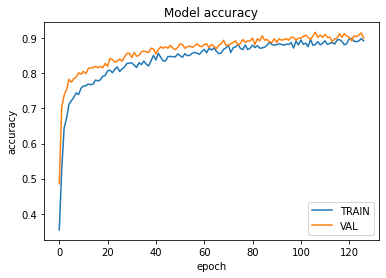

In [ ]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
# plt.figure(figsize = (7,10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [ ]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

19/19 [==============================] - 0s 3ms/step - loss: 0.4916 - accuracy: 0.8185


19/19 [==============================] - 0s 2ms/step
Confusion matrix, without normalization

Classification Report:
                  precision    recall  f1-score   support

          drive       0.66      0.94      0.77       145
legglance-flick       0.83      0.53      0.65       165
       pullshot       0.89      0.92      0.91       157
          sweep       0.98      0.93      0.96       128

       accuracy                           0.82       595
      macro avg       0.84      0.83      0.82       595
   weighted avg       0.84      0.82      0.81       595



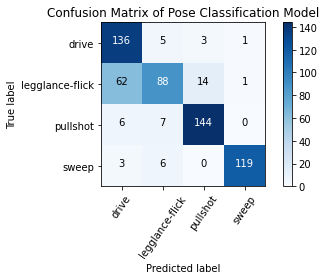

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

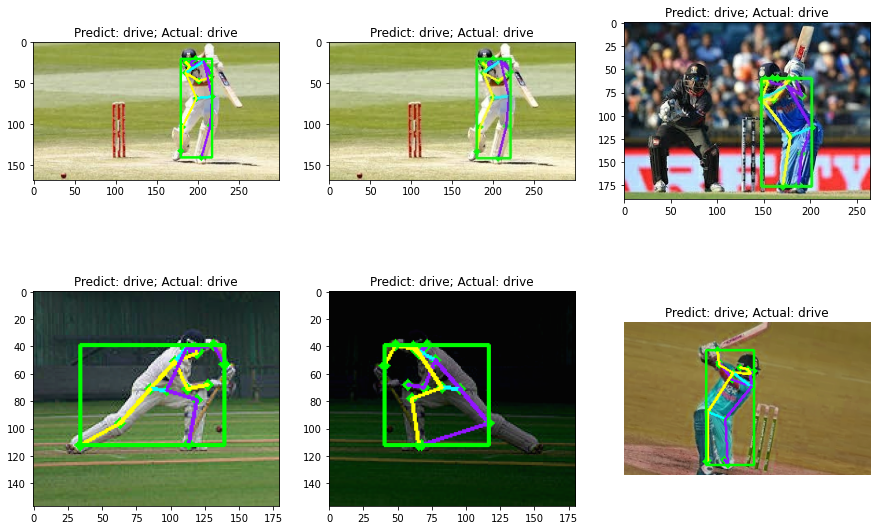

In [ ]:
IMAGE_PER_ROW = 3
MAX_NO_OF_IMAGE_TO_PLOT = 6

# Extract the list of correctly predicted poses
true_predict = [id_in_df for id_in_df in range(len(y_test)) \
                if y_pred_label[id_in_df] == y_true_label[id_in_df]]

if len(true_predict) > MAX_NO_OF_IMAGE_TO_PLOT:
  true_predict = true_predict[:MAX_NO_OF_IMAGE_TO_PLOT]

# Plot the correctly predicted images
row_count = len(true_predict) // IMAGE_PER_ROW + 1
fig = plt.figure(figsize=(5 * IMAGE_PER_ROW, 5 * row_count))

for i, id_in_df in enumerate(true_predict):
  ax = fig.add_subplot(row_count, IMAGE_PER_ROW, i + 1)
  image_path = os.path.join(images_out_test_folder,
                            df_test.iloc[id_in_df]['file_name'])

  image = cv2.imread(image_path)
  plt.title("Predict: %s; Actual: %s"
            % (y_pred_label[id_in_df], y_true_label[id_in_df]))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.axis("off")
plt.show()

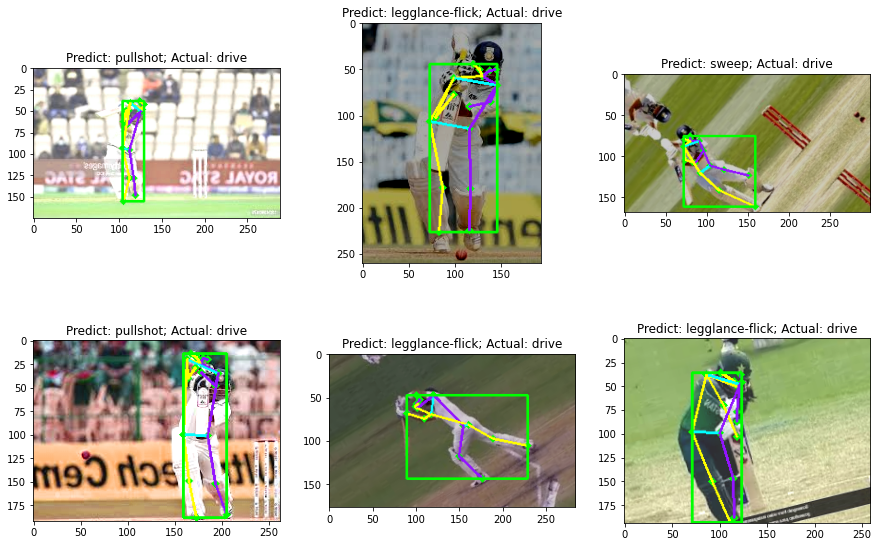

In [ ]:
IMAGE_PER_ROW = 3
MAX_NO_OF_IMAGE_TO_PLOT = 6

# Extract the list of incorrectly predicted poses
false_predict = [id_in_df for id_in_df in range(len(y_test)) \
                if y_pred_label[id_in_df] != y_true_label[id_in_df]]
                
if len(false_predict) > MAX_NO_OF_IMAGE_TO_PLOT:
  false_predict = false_predict[:MAX_NO_OF_IMAGE_TO_PLOT]

# Plot the incorrectly predicted images
row_count = len(false_predict) // IMAGE_PER_ROW + 1
fig = plt.figure(figsize=(5 * IMAGE_PER_ROW, 5 * row_count))

for i, id_in_df in enumerate(false_predict):
  ax = fig.add_subplot(row_count, IMAGE_PER_ROW, i + 1)

  image_path = os.path.join(images_out_test_folder,
                            df_test.iloc[id_in_df]['file_name'])

  image = cv2.imread(image_path)
  plt.title("Predict: %s; Actual: %s"
            % (y_pred_label[id_in_df], y_true_label[id_in_df]))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()